In [1]:
from skimage import io, transform, color
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import torchvision.transforms as T
from dataLoader import OrganoidDataset
from torch.utils import data
import numpy as np
import sys
import pandas as pd
from imageio import imread
from PIL import Image
import os
import math
import torchvision.models as models

from dataLoader import OrganoidDataset
#from conv_model import SimpleConvNet
import matplotlib.pyplot as plt
import copy

%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
dtype = torch.float32

params = {'batch_size': 100, # low for testing
          'shuffle': True, 'num_workers' : 2}
max_epochs = 100

figure_path = '../milestoneReport/figures/'
#path = '../data/CS231n_Tim_Shan_example_data/'
path = '../data/'
label_path = '../data/well_summary_A1_e0891BSA_all.csv'

## load data 

In [3]:
#indexes=[]
class OrganoidMultipleDataset(data.Dataset):
    'dataset class for microwell organoid images'
    def __init__(self, path2files, image_names, Y, mean_sd_dict, transforms=None):
        for k, image_name in image_names.items():
            assert len(image_name) == len(Y)
        self.path = path2files
        self.image_names = image_names
        self.Y = Y
        self.mean_sd_dict = mean_sd_dict
        self.transforms = transforms
    def __len__(self):
        return len(self.Y)
    def getXimage(self, index):
        all_images_list = []
        for day,img_names in self.image_names.items():
            #print(day, "   ", index)
            img_name = img_names[index]
            img_loc = os.path.join(self.path, img_name)
            image = io.imread(img_loc)
            mean, sd = self.mean_sd_dict[day]
            image = np.true_divide(color.rgb2gray(image) - mean, sd)
            all_images_list.append(image)
        images = np.array(all_images_list)
        return torch.from_numpy(images).float()
    def getY(self, index):
       
        Y = torch.from_numpy(np.asarray(self.Y[index], dtype=float)).float()

        return Y.view(-1)
    def __getitem__(self, index):
        X = self.getXimage(index)
        y = self.getY(index)
        if self.transforms is not None:
            X = self.transforms(X)
        #indexes.append(index)
        return X, y

In [4]:
training_labels = pd.read_csv('../data_description/A1_A2_C1_filtered_train_v2.csv')
validation_labels = pd.read_csv('../data_description/A1_A2_C1_filtered_validation_v2.csv')
test_labels = pd.read_csv('../data_description/A1_A2_C1_filtered_test_v2.csv')

#### filter for predict size

In [5]:
training_labels = training_labels.query('has_cell_13 == 1').reset_index()
validation_labels = validation_labels.query('has_cell_13 == 1').reset_index()
test_labels = test_labels.query('has_cell_13 == 1').reset_index()

In [6]:
training_labels.shape,validation_labels.shape,test_labels.shape

((3952, 61), (476, 61), (478, 61))

In [7]:
NUM_TRAIN = training_labels.shape[0]
NUM_VAL = validation_labels.shape[0]

In [8]:
NUM_TRAIN,NUM_VAL

(3952, 476)

In [9]:
training_labels.head(2)

,index,Unnamed: 0,condition,well_id,day_0,well_label,image_name_0,has_cell_0,hyst2_area_0,day_1,...,has_cell_11,hyst2_area_11,day_12,image_name_12,has_cell_12,hyst2_area_12,day_13,image_name_13,has_cell_13,hyst2_area_13
0,0,0,A1,64,0,64,well_A1/well0064_day00_well.png,0,0,1,...,0,0,12,well_A1/well0064_day12_well.png,0,0,13,well_A1/well0064_day13_well.png,1,172
1,2,2,A2,977,0,977,well_A2/well0977_day00_well.png,1,2568,1,...,1,3227,12,well_A2/well0977_day12_well.png,1,3063,13,well_A2/well0977_day13_well.png,1,3194


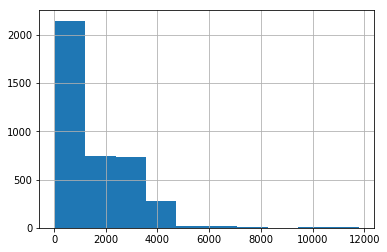

In [10]:
training_labels['hyst2_area_13'].hist()

In [11]:
training_labels['hyst2_area_13'].sort_values()

275        25
1139       25
3075       25
2537       25
3410       25
2722       25
3392       25
1482       25
3854       25
3846       25
1909       25
1030       25
449        25
1032       25
3248       25
2421       25
3039       25
3824       25
2149       25
2159       25
2207       25
3938       25
808        28
1419       28
2501       31
2084       31
3128       31
3268       33
3687       34
1847       34
        ...  
1865     6044
1593     6068
290      6150
55       6150
3787     6173
287      6174
2778     6503
249      6511
1904     6667
541      6774
3585     6801
3710     7054
1423     7342
3910     7696
3658     7812
1874     8186
1751     8247
77       8538
1775     9416
1942     9614
418      9758
3810     9888
1835     9964
3040    10467
2411    10683
3137    11266
1188    11320
3783    11485
16      11546
3506    11798
Name: hyst2_area_13, Length: 3952, dtype: int64

In [12]:
y_mean =  training_labels['hyst2_area_13'].mean()
y_std = training_labels['hyst2_area_13'].std()

In [13]:
y_mean, y_std

(1459.5837550607287, 1434.1085029549893)

In [14]:
training_labels['normalized_hyst2_area_13'] = (training_labels['hyst2_area_13'] - y_mean)/y_std
validation_labels['normalized_hyst2_area_13'] = (validation_labels['hyst2_area_13'] - y_mean)/y_std

In [15]:
training_image_names = {2:training_labels['image_name_2'],8:training_labels['image_name_8'], 5:training_labels['image_name_5']}
validation_image_names = {2:validation_labels['image_name_2'],8:validation_labels['image_name_8'],5:validation_labels['image_name_5']}

In [16]:
training_y = training_labels['normalized_hyst2_area_13']
validation_y = validation_labels['normalized_hyst2_area_13']
#test_y = test_labels['hyst2_area_13']

In [17]:
validation_y

0      1.413712
1      1.848825
2     -0.671904
3      3.763604
4      0.153696
5      0.026788
6     -0.829494
7     -0.829494
8     -0.221450
9      0.808458
10    -0.916656
11     0.990452
12     1.283317
13    -0.584045
14    -0.941758
15    -0.820429
16    -1.000331
17     0.715020
18     0.035852
19     1.031593
20     1.049025
21     0.100004
22     1.002306
23    -0.866450
24    -0.827402
25    -0.717926
26     1.020436
27     1.010674
28    -0.941061
29    -0.440402
         ...   
446   -0.890158
447   -0.975229
448   -0.793234
449    0.398447
450    0.011447
451   -0.977321
452   -0.476661
453   -0.916656
454    0.425642
455    0.188561
456   -0.939667
457   -0.851807
458    0.643896
459    0.936063
460    0.783355
461    0.135566
462   -0.899223
463   -0.728385
464    1.346771
465    0.947917
466   -0.775802
467   -0.508737
468    0.572074
469   -0.892250
470   -0.190072
471    0.023301
472   -0.732569
473   -0.570796
474    6.474696
475   -0.447375
Name: normalized_hyst2_a

In [18]:
training_y.shape

(3952,)

In [19]:
mean_sd_dict = {2: [0.49439774802337344, 0.16087996922691195],
 8: [0.5177020917650417, 0.15714445907773483],
 5: [0.5013496452715945, 0.1605951051365687],              }

In [25]:
train_set = OrganoidMultipleDataset(path2files = path, image_names = training_image_names, Y = training_y,mean_sd_dict=mean_sd_dict)
validation_set = OrganoidMultipleDataset(path2files = path, image_names = validation_image_names, Y = validation_y,mean_sd_dict=mean_sd_dict)
#test_set = OrganoidMultipleDataset(path2files = path, image_names = test_image_names, Y = test_labels['has_cell_13'],mean_sd_dict=mean_sd_dict)



In [26]:
training_generator = data.DataLoader(train_set, **params)
val_params = {'batch_size': 100, # low for testing
          'shuffle': True, 'num_workers' : 2}
validation_generator = data.DataLoader(validation_set, **val_params)
#test_generator = data.DataLoader(test_set, **params)

### Model

In [27]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


In [28]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

def test_flatten():
    x = torch.arange(12).view(2, 1, 3, 2)
    print('Before flattening: ', x)
    print('After flattening: ', flatten(x))

test_flatten()
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

Before flattening:  tensor([[[[ 0,  1],
          [ 2,  3],
          [ 4,  5]]],


        [[[ 6,  7],
          [ 8,  9],
          [10, 11]]]])
After flattening:  tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11]])


In [29]:
NUM_TRAIN

3952

In [30]:
def check_accuracy_part34(loader, model,dataset='validation'):
    num_correct = 0
    num_samples = 0
    losses = []
    model.eval()  # set model to evaluation mode
    if dataset=='validation':
        num = NUM_VAL
    else:
        num = NUM_TRAIN
    with torch.no_grad():
        totalbatchMSE = 0.0
        all_prediction = []
        all_y = []
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)
            #print("size:" , x.size())
            preds = model(x)
            
            val_loss = F.mse_loss(preds, y)
            val_error = val_loss.item()
            losses.append(val_error)
            #totalbatchMSE = totalbatchMSE + params['batch_size']*val_error/NUM_VAL
            totalbatchMSE = totalbatchMSE + params['batch_size']*val_error/num
            all_prediction.append(preds.cpu().numpy())
            all_y.append(y.cpu().numpy())
        print('Got %s mean square error (%.4f)' % (dataset,100 * val_error))
        print('totalbatchMSE',totalbatchMSE)
        #print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return totalbatchMSE,all_prediction, all_y

In [31]:
def train_part34(model, optimizer, epochs=1,lr_scheduler=None):
    best_model = None
    best_validation_accuracy = -1
    
    losses = []
    validation_accuracy = []
    training_accuracy = []
    prediction = []
    y_true = []
    model = model.to(device=device)  # move the model parameters to CPU/GPU

        
    for e in range(epochs):
        print('epoch:',e)
        totalbatchMSE = 0.0
        
        if lr_scheduler is not None:
            lr_scheduler.step()
            print('LR:', lr_scheduler.get_lr())
        for t, (x, y) in enumerate(training_generator):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)

            Y_hat = model(x)
            #loss = nn.MSELoss(Y_hat,y)
#             print(Y_hat.type())
#             print(y.type())
            loss = F.mse_loss(Y_hat, y)
            
            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            
            train_error = loss.item()
            
            totalbatchMSE = totalbatchMSE + params['batch_size']*train_error/NUM_TRAIN
            
            #losses.append(train_error)
            losses.append(train_error)
            #epoch_error[e] = totalbatchMSE

            if t % print_every == 0:

                print('Iteration %d, loss = %.4f' % (t, train_error))
                train_acc, _, _ = check_accuracy_part34(training_generator, model, dataset='training')
                
                training_accuracy.append(train_acc)
                validation_acc, preds ,y= check_accuracy_part34(validation_generator, model,dataset='validation')
                validation_accuracy.append(validation_acc)
                #prediction.append(preds)
                
                if validation_acc > best_validation_accuracy:
                    best_validation_accuracy = validation_acc
                    best_model = copy.deepcopy(model)
                    prediction = preds
                    y_ture = y


                print()

        
                        
#     checkpoint = {'model': best_model,
#                 'state_dict': model.state_dict()
#                }

#     torch.save(checkpoint, 'classification_checkpoint.pth')
    #torch.save(best_model.state_dict(), 'classification_model.pth')
    return losses, validation_accuracy, training_accuracy, prediction,best_model,y_ture

## original model

In [350]:
# in_channels = 2 
# channel_1 = 32
# channel_2 = 16
# channel_3 = 8
# out_size = 1
# image_size = int(193/2/2)
# image_size = 193
# model = nn.Sequential(
#     nn.Conv2d(in_channels=in_channels,out_channels=32,kernel_size=5,padding=2,bias=True),
#     nn.ReLU(),
#     nn.MaxPool2d(2),
#     nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1,bias=True),
#     nn.ReLU(), 
#     nn.MaxPool2d(2),
#     nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1,bias=True),
#     nn.ReLU(),  
#     nn.MaxPool2d(2),
#     nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1,bias=True),
#     nn.ReLU(),  
#     nn.MaxPool2d(2),
#     nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,padding=1,bias=True),
#     nn.ReLU(),  
#     nn.MaxPool2d(2),
    
#     nn.Dropout(),
#     Flatten(),
#     nn.Linear(256*6*6, out_size),
# )

## pretrained Resnet 

In [32]:
resnet18 = models.resnet18()
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)

## Train models

In [33]:
model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [34]:
print_every = 100
epoches = 5
learning_rate = 1e-4

optimizer =optim.Adam(model.parameters(), lr=learning_rate)

losses,validation_accuracy, training_accuracy,prediction,best_model,y = train_part34(model, optimizer,epochs=epoches)

epoch: 0
Iteration 0, loss = 1.0304
Got training mean square error (35.2378)
totalbatchMSE 0.9205639543320968
Got validation mean square error (74.9516)
totalbatchMSE 1.253951059169128

epoch: 1
Iteration 0, loss = 0.1015
Got training mean square error (30.3290)
totalbatchMSE 0.20351225740242346
Got validation mean square error (46.5863)
totalbatchMSE 0.5583170770096177

epoch: 2
Iteration 0, loss = 0.0878
Got training mean square error (6.9832)
totalbatchMSE 0.10386673047354346
Got validation mean square error (20.7848)
totalbatchMSE 0.5599671739990972

epoch: 3
Iteration 0, loss = 0.0736
Got training mean square error (3.6140)
totalbatchMSE 0.04360600099389852
Got validation mean square error (22.6230)
totalbatchMSE 0.5697607399285342

epoch: 4
Iteration 0, loss = 0.0282
Got training mean square error (2.8509)
totalbatchMSE 0.03218259332467791
Got validation mean square error (16.9755)
totalbatchMSE 0.56204212939038



In [35]:
torch.save(best_model.state_dict(), 'regression_model.pth')

In [44]:
checkpoint = {'model': best_model,
                 'state_dict': best_model.state_dict()
                }
torch.save(checkpoint, 'regression_checkpoint.pth')

# plot

In [36]:
def plot_loss(losses=losses):
    fig = plt.figure()
    plt.subplot(2, 1, 2)
    plt.plot(losses, '.-')
    plt.title("Loss history")
    plt.ylim(0)
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.show()

def plot_accuracies(training_accuracy=training_accuracy, validation_accuracy=validation_accuracy):
    fig = plt.figure()
    plt.subplot(2, 1, 2)
    plt.plot(training_accuracy, '.-')
    plt.plot(validation_accuracy, '.-')
    plt.title("training and validation MSE")
    plt.ylim(0,1)
    plt.legend(['train', 'val'], loc='upper right')
    plt.xlabel('epoch')
    plt.ylabel('MSE')
    plt.show()
    #fig.savefig(figure_path+'train_val_MSE.pdf')
def print_best_loss_and_accuracy(losses,validation_accuracy,training_accuracy):
    loss = min(losses)
    val_acc = min(validation_accuracy)
    train_acc = min(training_accuracy)
    print("Minimum loss: %.4f"%loss )
    print("best training accuracy %.4f"%train_acc)
    print("Best validation accuracy %.4f"%val_acc)
    return loss, val_acc, train_acc

In [37]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)

# pretrain for 3k

In [38]:
min_loss, best_val_mse, best_train_mse = print_best_loss_and_accuracy(losses,validation_accuracy,training_accuracy)

Minimum loss: 0.0115
best training accuracy 0.0322
Best validation accuracy 0.5583


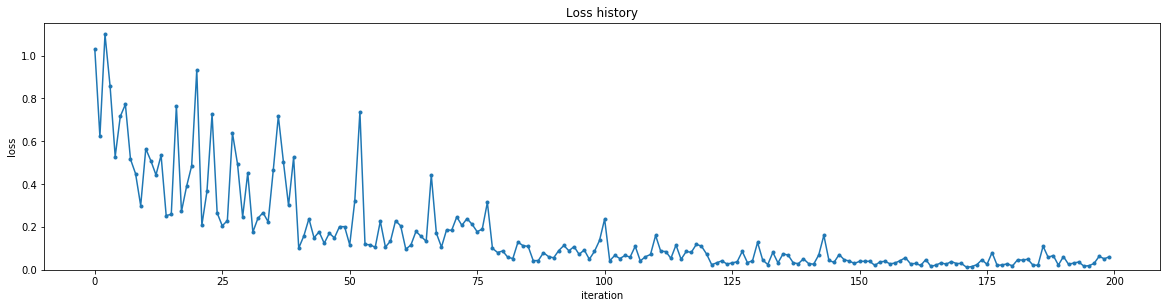

In [39]:
plot_loss(losses)

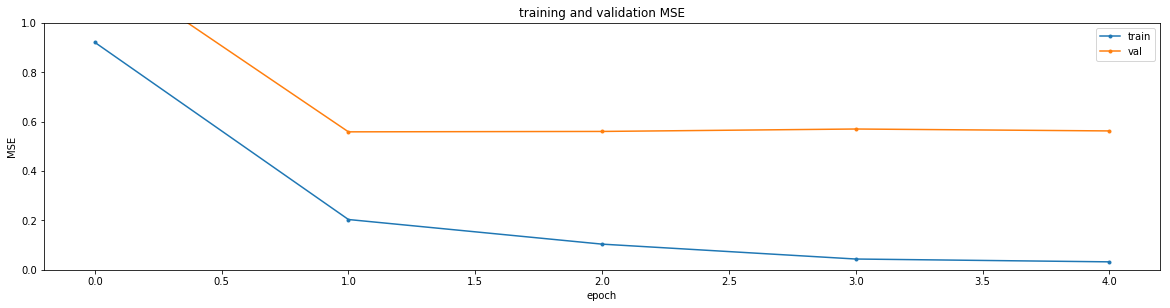

In [40]:
plot_accuracies(training_accuracy, validation_accuracy)

# plot prediction

In [46]:
new_model = torch.load('regression_checkpoint.pth')['model']
new_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [24]:
model.load_state_dict(torch.load('regression_model.pth'))

AttributeError: 'collections.OrderedDict' object has no attribute 'load_state_dict'

In [47]:
val_params = {'batch_size': NUM_VAL, # low for testing
          'shuffle': False, 'num_workers' : 2}
new_validation_generator = data.DataLoader(validation_set, **val_params)
for x, y in new_validation_generator:
    x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
    y = y.to(device=device, dtype=dtype)
    y_hat = new_model(x)

In [48]:
prediction

[array([[-0.43132603],
        [-0.01771821],
        [-0.38203096],
        [-0.03589143],
        [ 0.04811542],
        [-0.01499215],
        [ 0.05104095],
        [-0.02321112],
        [ 0.49919587],
        [-0.00187869],
        [ 0.17204791],
        [-0.19103675],
        [-0.12204824],
        [-0.21834855],
        [-0.8516976 ],
        [ 0.05892497],
        [ 0.3043091 ],
        [ 0.62037975],
        [-0.67246276],
        [-0.988211  ],
        [-0.03570774],
        [-0.00741755],
        [-0.17319806],
        [-0.30749232],
        [-0.18903397],
        [-0.3028612 ],
        [-0.5785305 ],
        [-0.3466847 ],
        [-0.48533845],
        [-0.43626884],
        [-0.34519774],
        [-0.01007332],
        [-0.61470675],
        [-0.3866896 ],
        [-0.47072268],
        [-0.13181333],
        [-0.21070573],
        [ 0.02112235],
        [-0.19380255],
        [-0.843409  ],
        [ 0.20929575],
        [ 0.01403449],
        [-0.388767  ],
        [-0

In [503]:
np_y = y.cpu().numpy()

In [504]:
np_prediction = y_hat.cpu().numpy()

RuntimeError: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.

In [405]:
unnormalized_prediction = (np_prediction * y_std) + y_mean

In [406]:
validation_labels.shape

(476, 62)

In [407]:
unnormalized_prediction.shape

(476, 1)

In [408]:
val_set = validation_labels.copy()

In [409]:
val_set['original_size_prediction'] = unnormalized_prediction
val_set['prediction'] = np_prediction

In [411]:
validation_result = val_set[['well_id','well_label','hyst2_area_13',
       'normalized_hyst2_area_13', 'original_size_prediction', 'prediction']]

In [412]:
from sklearn.metrics import mean_squared_error
mean_squared_error(validation_result['normalized_hyst2_area_13'],
                   validation_result['prediction'])

2.330377003875991

In [416]:
mean_squared_error(np_y,
                   np_prediction)

0.530266

In [435]:
validation_y

0      1.413712
1      1.848825
2     -0.671904
3      3.763604
4      0.153696
5      0.026788
6     -0.829494
7     -0.829494
8     -0.221450
9      0.808458
10    -0.916656
11     0.990452
12     1.283317
13    -0.584045
14    -0.941758
15    -0.820429
16    -1.000331
17     0.715020
18     0.035852
19     1.031593
20     1.049025
21     0.100004
22     1.002306
23    -0.866450
24    -0.827402
25    -0.717926
26     1.020436
27     1.010674
28    -0.941061
29    -0.440402
         ...   
446   -0.890158
447   -0.975229
448   -0.793234
449    0.398447
450    0.011447
451   -0.977321
452   -0.476661
453   -0.916656
454    0.425642
455    0.188561
456   -0.939667
457   -0.851807
458    0.643896
459    0.936063
460    0.783355
461    0.135566
462   -0.899223
463   -0.728385
464    1.346771
465    0.947917
466   -0.775802
467   -0.508737
468    0.572074
469   -0.892250
470   -0.190072
471    0.023301
472   -0.732569
473   -0.570796
474    6.474696
475   -0.447375
Name: normalized_hyst2_a

In [417]:
np_y

array([[ 7.45701075e-01],
       [-9.34785426e-01],
       [ 6.02057815e-01],
       [ 4.25641596e-01],
       [-9.09682751e-01],
       [ 1.46722674e-01],
       [-3.98563802e-01],
       [-9.59888160e-01],
       [ 6.82247043e-01],
       [ 1.07831192e+00],
       [-6.81666493e-01],
       [-6.80969238e-01],
       [-5.84044874e-01],
       [-6.30763829e-01],
       [-4.47374612e-01],
       [ 9.38852429e-01],
       [-7.13044882e-01],
       [ 1.04344702e+00],
       [-1.36556998e-02],
       [-9.18050289e-01],
       [-9.27115202e-01],
       [ 1.85074031e-01],
       [-9.10380065e-01],
       [-7.93234110e-01],
       [-9.52915192e-01],
       [ 3.98447007e-01],
       [-8.17639470e-01],
       [-7.10255682e-01],
       [-9.41758394e-01],
       [ 2.65908480e+00],
       [ 1.50645244e+00],
       [ 4.63295668e-01],
       [-9.59888160e-01],
       [ 4.77064624e-02],
       [ 1.50854433e+00],
       [-8.23217869e-01],
       [-2.21450299e-01],
       [ 1.58576742e-01],
       [-8.6

In [347]:
validation_result

,well_id,well_label,hyst2_area_13,normalized_hyst2_area_13,original_size_prediction,prediction
0,3362,3362,3487,1.413712,905.940918,-0.386054
1,2413,2413,4111,1.848825,1421.096924,-0.026837
2,184,184,496,-0.671904,659.989075,-0.557555
3,203,203,6857,3.763604,1165.305908,-0.205199
4,2752,2752,1680,0.153696,1943.992432,0.337777
5,3198,3198,1498,0.026788,881.928528,-0.402797
6,2637,2637,270,-0.829494,1245.494507,-0.149284
7,10,10,270,-0.829494,1122.139038,-0.235299
8,1652,1652,1142,-0.221450,1410.609741,-0.034149
9,123,123,2619,0.808458,1222.522827,-0.165302


In [352]:
pred_truth_correlation = validation_result['hyst2_area_13'].corr(validation_result['original_size_prediction'])

In [353]:
pred_truth_correlation

0.06054219263089131

In [354]:
val_prediction = validation_result.set_index('hyst2_area_13')['original_size_prediction']

Text(0.5, 1.0, 'day13 size prediction and observation')

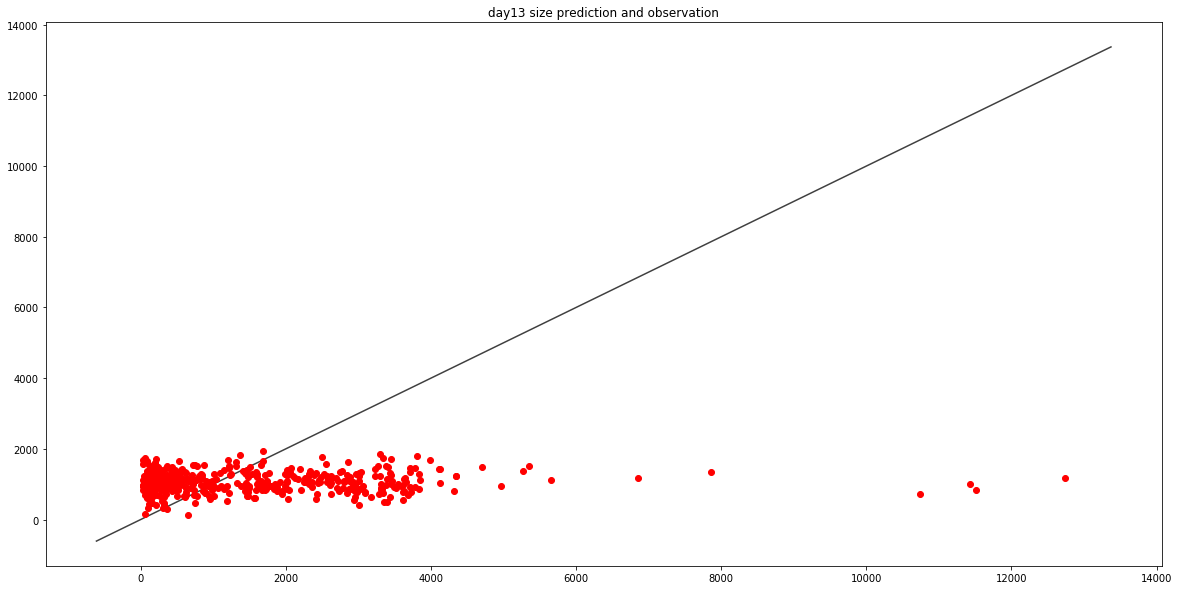

In [355]:
#fig = plt.figure()
fig, ax = plt.subplots( nrows=1, ncols=1 )
plt.plot(validation_result['hyst2_area_13'],validation_result['original_size_prediction'], 'o',color='r' )
#ax = validation_result.plot(kind='scatter', x='original_hyst2_area_13', y='original_size_prediction', color='r')  
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
#plt.set_aspect('equal')
plt.title("day13 size prediction and observation")

In [497]:
validation_set

In [498]:

    #indexes = i.to(device=device, dtype=dtype)

In [499]:
validation_y

0      1.413712
1      1.848825
2     -0.671904
3      3.763604
4      0.153696
5      0.026788
6     -0.829494
7     -0.829494
8     -0.221450
9      0.808458
10    -0.916656
11     0.990452
12     1.283317
13    -0.584045
14    -0.941758
15    -0.820429
16    -1.000331
17     0.715020
18     0.035852
19     1.031593
20     1.049025
21     0.100004
22     1.002306
23    -0.866450
24    -0.827402
25    -0.717926
26     1.020436
27     1.010674
28    -0.941061
29    -0.440402
         ...   
446   -0.890158
447   -0.975229
448   -0.793234
449    0.398447
450    0.011447
451   -0.977321
452   -0.476661
453   -0.916656
454    0.425642
455    0.188561
456   -0.939667
457   -0.851807
458    0.643896
459    0.936063
460    0.783355
461    0.135566
462   -0.899223
463   -0.728385
464    1.346771
465    0.947917
466   -0.775802
467   -0.508737
468    0.572074
469   -0.892250
470   -0.190072
471    0.023301
472   -0.732569
473   -0.570796
474    6.474696
475   -0.447375
Name: normalized_hyst2_a

In [470]:
len(indexes)

0

In [500]:
y

tensor([[ 1.4137e+00],
        [ 1.8488e+00],
        [-6.7190e-01],
        [ 3.7636e+00],
        [ 1.5370e-01],
        [ 2.6788e-02],
        [-8.2949e-01],
        [-8.2949e-01],
        [-2.2145e-01],
        [ 8.0846e-01],
        [-9.1666e-01],
        [ 9.9045e-01],
        [ 1.2833e+00],
        [-5.8404e-01],
        [-9.4176e-01],
        [-8.2043e-01],
        [-1.0003e+00],
        [ 7.1502e-01],
        [ 3.5852e-02],
        [ 1.0316e+00],
        [ 1.0490e+00],
        [ 1.0000e-01],
        [ 1.0023e+00],
        [-8.6645e-01],
        [-8.2740e-01],
        [-7.1793e-01],
        [ 1.0204e+00],
        [ 1.0107e+00],
        [-9.4106e-01],
        [-4.4040e-01],
        [-3.3232e-01],
        [ 5.7696e-01],
        [-5.9032e-01],
        [-9.0968e-01],
        [-4.0414e-01],
        [ 3.8311e-01],
        [ 6.9131e-01],
        [-7.8626e-01],
        [ 9.3551e-03],
        [-8.7621e-01],
        [ 1.5085e+00],
        [-7.7441e-01],
        [ 9.6465e-01],
        [ 6

In [501]:
y_hat

tensor([[ 1.5595e+00],
        [-8.6820e-01],
        [-5.4880e-01],
        [ 1.4172e+00],
        [ 8.3298e-01],
        [-7.9306e-01],
        [-1.4648e-01],
        [-8.5228e-01],
        [ 2.6408e-01],
        [ 1.1353e+00],
        [-5.5413e-01],
        [ 1.0838e+00],
        [ 1.2885e+00],
        [-5.1470e-01],
        [-4.9065e-01],
        [-3.7118e-01],
        [-6.6284e-01],
        [ 1.9464e-01],
        [ 8.1778e-01],
        [ 1.0282e+00],
        [ 4.7550e-01],
        [ 1.0401e+00],
        [ 1.0658e+00],
        [-8.1743e-01],
        [-5.4959e-01],
        [-8.9191e-01],
        [ 5.1409e-01],
        [ 1.0540e+00],
        [-6.8063e-01],
        [-3.0010e-01],
        [-3.0973e-01],
        [ 6.0255e-01],
        [-7.8086e-01],
        [-7.8863e-01],
        [-6.7364e-01],
        [ 3.6129e-01],
        [ 7.6090e-01],
        [ 2.0642e-01],
        [ 2.9946e-01],
        [-7.1466e-01],
        [ 1.1700e+00],
        [-6.1372e-01],
        [ 7.4375e-01],
        [ 6